**This workbook will aim at implementing an example use this cryptobacktest library**

The strategy we aim to implement is an options-based approach designed to capture potential increases in the volatility of the underlying asset. Specifically, we will utilize a strategy known as a straddle, which involves simultaneously purchasing a call and a put option with the same strike price and expiration date. This setup allows us to profit from significant price movements in either direction. To identify potential opportunities, we will focus on periods of low volatility, anticipating that an increase in volatility may follow.

In [5]:
#import cryptobacktest
from cryptobacktest.option import Option

from pybacktestchain.data_module import *
from cryptobacktest.volatility import *


In [6]:
# Define the date range
start_date = "2016-01-01"
end_date = "2024-12-31"

# Import historical data thanks to a pybacktestchain function
btc_data = get_stock_data('BTC-USD', start_date, end_date)
btc_data

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2016-01-01 00:00:00+00:00,430.721008,436.246002,427.515015,434.334015,434.334015,36278900,BTC-USD
1,2016-01-02 00:00:00+00:00,434.622009,436.062012,431.869995,433.437988,433.437988,30096600,BTC-USD
2,2016-01-03 00:00:00+00:00,433.578003,433.743011,424.705994,430.010986,430.010986,39633800,BTC-USD
3,2016-01-04 00:00:00+00:00,430.061005,434.516998,429.084015,433.091003,433.091003,38477500,BTC-USD
4,2016-01-05 00:00:00+00:00,433.069000,434.182007,429.675995,431.959991,431.959991,34522600,BTC-USD
...,...,...,...,...,...,...,...,...
3282,2024-12-26 00:00:00+00:00,99297.695312,99884.570312,95137.882812,95795.515625,95795.515625,47054980873,BTC-USD
3283,2024-12-27 00:00:00+00:00,95704.976562,97294.843750,93310.742188,94164.859375,94164.859375,52419934565,BTC-USD
3284,2024-12-28 00:00:00+00:00,94160.187500,95525.898438,94014.289062,95163.929688,95163.929688,24107436185,BTC-USD
3285,2024-12-29 00:00:00+00:00,95174.054688,95174.875000,92881.789062,93530.226562,93530.226562,29635885267,BTC-USD


We will be working on the closing prices so we will only keep them.

In [7]:
btc_close = btc_data[['Date', 'Close']].copy()

#btc_close['Date'] = pd.to_datetime(btc_close['Date']).dt.strftime('%Y-%m-%d')

# Display the DataFrame
btc_close

,Date,Close
0,2016-01-01 00:00:00+00:00,434.334015
1,2016-01-02 00:00:00+00:00,433.437988
2,2016-01-03 00:00:00+00:00,430.010986
3,2016-01-04 00:00:00+00:00,433.091003
4,2016-01-05 00:00:00+00:00,431.959991
...,...,...
3282,2024-12-26 00:00:00+00:00,95795.515625
3283,2024-12-27 00:00:00+00:00,94164.859375
3284,2024-12-28 00:00:00+00:00,95163.929688
3285,2024-12-29 00:00:00+00:00,93530.226562


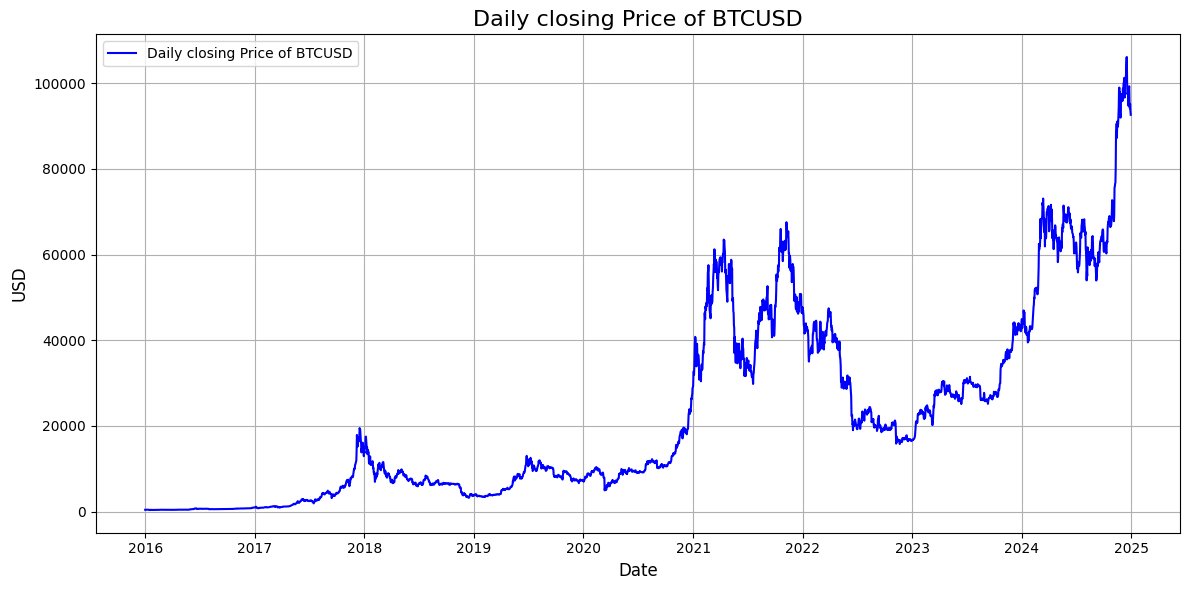

In [16]:
# Plot the Price
plt.figure(figsize=(12, 6))
plt.plot(btc_close['Date'], btc_close['Close'], label='Daily closing Price of BTCUSD', color='blue')
plt.title('Daily closing Price of BTCUSD', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('USD', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Initialize the Volatility to compute a monthly volatility over a yearly rolling window

In [8]:
volatility_calculator = Volatility(window=360,factor=30)

# Compute monthly rolling volatility
btc_close = volatility_calculator.compute_volatility(btc_close, price_column='Close', date_column='Date')

In [9]:
btc_close

,Date,Close,Volatility
0,2016-01-01 00:00:00+00:00,434.334015,NaN
1,2016-01-02 00:00:00+00:00,433.437988,NaN
2,2016-01-03 00:00:00+00:00,430.010986,NaN
3,2016-01-04 00:00:00+00:00,433.091003,NaN
4,2016-01-05 00:00:00+00:00,431.959991,NaN
...,...,...,...
3282,2024-12-26 00:00:00+00:00,95795.515625,0.154039
3283,2024-12-27 00:00:00+00:00,94164.859375,0.154077
3284,2024-12-28 00:00:00+00:00,95163.929688,0.153431
3285,2024-12-29 00:00:00+00:00,93530.226562,0.153314


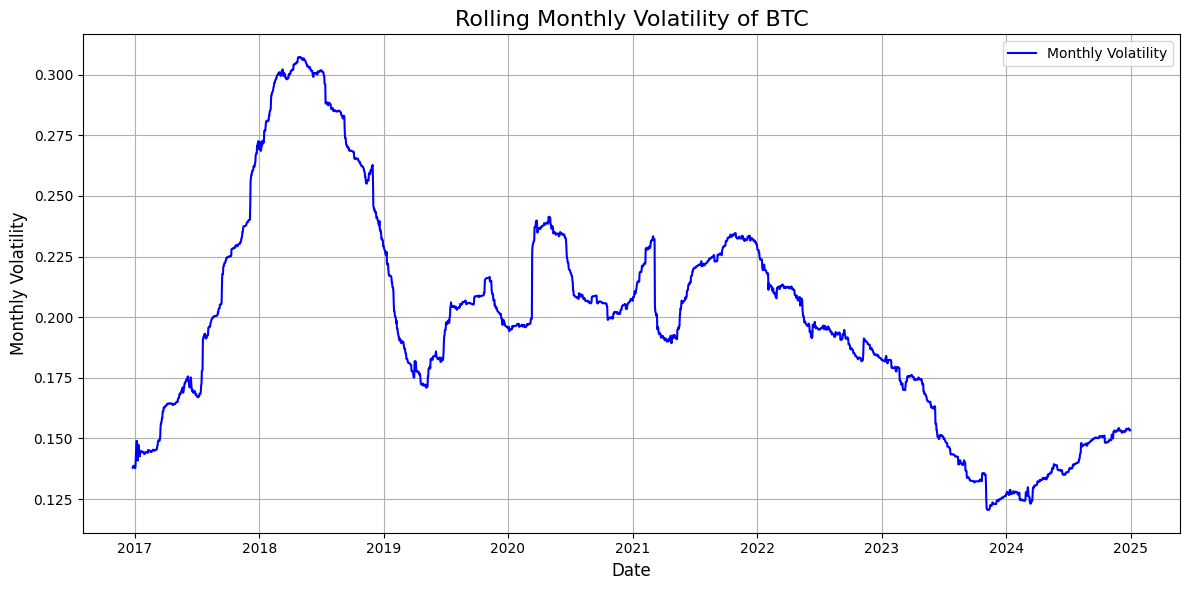

In [11]:
# Plot the monthly rolling  volatility
plt.figure(figsize=(12, 6))
plt.plot(btc_close['Date'], btc_close['Volatility'], label='Monthly Volatility', color='blue')
plt.title('Rolling Monthly Volatility of BTC', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Monthly Volatility', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Compute the 30-day maturity straddle price for each dates


In [12]:
btc_close['StraddlePrice'] = btc_close.apply(
    lambda row: Option.compute_straddle(
        underlying_price=row['Close'],
        implied_volatility=row['Volatility'],
        time_to_maturity=30,  # 30-day maturity
        interest_rate=0.0,    # No interest rate
        dividend_yield=0.0    # No dividend yield
    ) if not pd.isna(row['Volatility']) else None,
    axis=1
)

btc_close

,Date,Close,Volatility,StraddlePrice
0,2016-01-01 00:00:00+00:00,434.334015,NaN,NaN
1,2016-01-02 00:00:00+00:00,433.437988,NaN,NaN
2,2016-01-03 00:00:00+00:00,430.010986,NaN,NaN
3,2016-01-04 00:00:00+00:00,433.091003,NaN,NaN
4,2016-01-05 00:00:00+00:00,431.959991,NaN,NaN
...,...,...,...,...
3282,2024-12-26 00:00:00+00:00,95795.515625,0.154039,3398.507632
3283,2024-12-27 00:00:00+00:00,94164.859375,0.154077,3341.501696
3284,2024-12-28 00:00:00+00:00,95163.929688,0.153431,3362.778973
3285,2024-12-29 00:00:00+00:00,93530.226562,0.153314,3302.548250
